* Look at daily integral of freshwater transport with and withou Coriolis, and the averaged salinity in the English Bay.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
import matplotlib.dates as md
import wind
import pandas as pd
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139},
            '6':{'jst':55,  'ist': 1,'jen':56,'ien':25},
            '7':{'jst':25,'ist':1, 'jen':26,'ien':25}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [5]:
## load salinity into a dict
pathsoct = ['Oct2014nof','Oct2014combineall']
pathsmay = ['May2015nof','May2015combineall']
pathsjan = ['Jan2016nof','Jan2016combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternTs = ['oct2014*_T.nc','may2015*_T.nc','jan2016*_T.nc']
file_patternUs = ['oct2014*_U.nc','may2015*_U.nc','jan2016*_U.nc']
file_patternVs = ['oct2014*_V.nc','may2015*_V.nc','jan2016*_V.nc']
U = {}; V={}; S={};ssh = {}
paths = [pathsoct,pathsmay,pathsjan]
for paa,Tfile, Ufile,Vfile in zip(paths,file_patternTs,file_patternUs,file_patternVs):
    for pa in paa:
        pathT = glob(os.path.join(base,pa, Tfile))
        pathU = glob(os.path.join(base,pa, Ufile))
        pathV = glob(os.path.join(base,pa, Vfile))
        fU = nc.Dataset(pathU[0],'r');
        U[pa] = fU.variables['vozocrtx']
        fV = nc.Dataset(pathV[0],'r');
        V[pa] = fV.variables['vomecrty']
        fT = nc.Dataset(pathT[0],'r');
        S[pa] = fT.variables['vosaline']
        lon = fT.variables['nav_lon'] 
        lat = fT.variables['nav_lat']
        ssh[pa] = fT.variables['sossheig']
        time_counter = fT.variables['time_counter']
        depT = fT.variables['deptht']

In [6]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """to calculate the total transport (False)or fresh water transport (True) in the entire water column 
    with focus on a continous time period rather than a specific time"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst']-1,transects[tran]['jen'])
    iinds = np.arange(transects[tran]['ist']-1,transects[tran]['ien'])
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st[pa],t_en[pa]+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depT,tran,t_st,t_en,\
                                                 paths,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [7]:
def transport_time_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j+1,1])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst']+1,transects[tran]['ist']+1]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,1,i+1])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst']+1,i+transects[tran]['ist']+1]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st[pa]:t_en[pa]+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st[pa]:t_en[pa]+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [8]:
def transportDaily_series(S,U,V,ssh,lon,lat,depT,dep,tran,tst,ten,paths,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for daily case, over selected depths"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 paths,fresh_flag = fresh_flag)
    inte_trans = {}; 
    for ty in paths:
        inte_trans[ty] = np.zeros((ten[ty]-tst[ty]+1)/24)
        for i in np.arange(tst[ty],ten[ty]+1,24): ## intergral individual daily
            inte_trans[ty][i/24-tst[ty]/24] = np.nansum(trans[ty][i:i+24,depT[0]:depT[dep]+1])*3600
    return inte_trans

# Calculation

In [9]:
paths = pathsmay
tst = {'May2015nof':0,'May2015combineall':0}
ten = {'May2015nof':743,'May2015combineall':743}
inte_weak_May = transportDaily_series(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [28]:
paths = pathsjan
tst = {'Jan2016nof':0,'Jan2016combineall':0}
ten = {'Jan2016nof':743,'Jan2016combineall':743}
inte_weak_Jan = transportDaily_series(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [35]:
paths = pathsoct
tst = {'Oct2014nof':0,'Oct2014combineall':0}
ten = {'Oct2014nof':743,'Oct2014combineall':743}
inte_weak_Oct = transportDaily_series(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# get wind results

In [11]:
def get_OPwinds(stationsOP,OPlon,OPlat,filesOP,j,i,duration,sax,eax):
    "This function was made to get model winds' speed and direction"
    wind_speed = {}; wind_dir = {}; time = {}; lat={}; lon={}; press={}; temp={}; therm={};
    solar={}; precip={}; qair={}; lon = {};lat = {};

    for  modOP in stationsOP:   
        
        [j,i]=wind.find_model_point(X[j,i],Y[j,i],OPlon,OPlat)
        lon[modOP] = OPlon[j,i]
        lat[modOP]=OPlat[j,i]
        print(j,i,lon[modOP],lat[modOP])

        [wind_speed[modOP],wind_dir[modOP],time[modOP],
         press[modOP],temp[modOP],solar[modOP],
         therm[modOP],qair[modOP],precip[modOP]] = wind.compile_OP(filesOP,j,i)    
      
    return wind_speed, wind_dir

In [12]:
import glob
X = grid6.variables['nav_lon']
Y = grid6.variables['nav_lat']
OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m05d01.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m05d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-May-2015'; end = '31-May-2015';
start2 = '31-May-2015'; end2 = '31-May-2015';
endd = '31-May-2015';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speedMay,wind_dirMay =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                       27,sax,eax)

135 151 -123.302707487 49.0907848354


In [13]:
## May
wind_dir_correctMay = []
for dire in wind_dirMay['Sandheads_OP']:
    dire_corre = 450 - dire
    wind_dir_correctMay.append(dire_corre)
df_may = pd.DataFrame({"speed": wind_speedMay['Sandheads_OP'], "direction": wind_dir_correctMay})

In [14]:
u_may = np.zeros([1,len(df_may)])
v_may = np.zeros([1,len(df_may)])
for i in np.arange(len(df_may)):
    u_may[0,i] = df_may.speed[i] * np.cos((450-df_may.direction[i])*np.pi/180) ## eastward
    v_may[0,i] = df_may.speed[i] * np.sin((450-df_may.direction[i])*np.pi/180) ## northward

In [31]:
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2016m01d*.nc')
filesOP.sort(key=os.path.basename)
start = '1-Jan-2016'; end = '31-Jan-2016';
start2 = '31-Jan-2016'; end2 = '31-Jan-2016';
endd = '31-Jan-2016';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speedJan,wind_dirJan =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                       27,sax,eax)

135 151 -123.302707487 49.0907848354


In [32]:
## Jan
wind_dir_correctJan = []
for dire in wind_dirJan['Sandheads_OP']:
    dire_corre =  450 - dire 
    wind_dir_correctJan.append(dire_corre)
df_jan = pd.DataFrame({"speed": wind_speedJan['Sandheads_OP'], "direction": wind_dir_correctJan})

In [33]:
u_jan = np.zeros([1,len(df_jan)])
v_jan = np.zeros([1,len(df_jan)])
for i in np.arange(len(df_jan)):
    u_jan[0,i] = df_jan.speed[i] * np.cos((450-df_jan.direction[i])*np.pi/180)
    v_jan[0,i] = df_jan.speed[i] * np.sin((450-df_jan.direction[i])*np.pi/180)

In [36]:
filesOP = glob.glob('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d*.nc')
filesOP.sort(key=os.path.basename)

OP = nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2014m10d01.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]

start = '1-Oct-2014'; end = '31-Oct-2014';
start2 = '31-Oct-2014'; end2 = '31-Oct-2014';
endd = '31-Oct-2014';
stations = ['Sandheads']; stationsOP =['Sandheads_OP'];
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(endd,'%d-%b-%Y')

wind_speed,wind_dir =get_OPwinds(stationsOP,OPlon,OPlat,filesOP,426,293,\
                            27,sax,eax)

135 151 -123.302707487 49.0907848354


In [37]:
## Oct
wind_dir_correct = []
for dire in wind_dir['Sandheads_OP']:
    dire_corre =  450 - dire
    wind_dir_correct.append(dire_corre)
## load into a pandas frame
df_oct = pd.DataFrame({"speed": wind_speed['Sandheads_OP'], "direction": wind_dir_correct})

In [38]:
u_oct = np.zeros([1,len(df_oct)])
v_oct = np.zeros([1,len(df_oct)])
for i in np.arange(len(df_oct)):
    u_oct[0,i] = df_oct.speed[i] * np.cos((450-df_oct.direction[i])*np.pi/180)
    v_oct[0,i] = df_oct.speed[i] * np.sin((450-df_oct.direction[i])*np.pi/180)

# Plot flux

In [16]:
t_start = datetime.datetime(2015,5,1,0,30)
t_end = datetime.datetime(2015,5,31,23,30)
t_daily = [datetime.datetime(2015,5,d,23,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2015,5,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

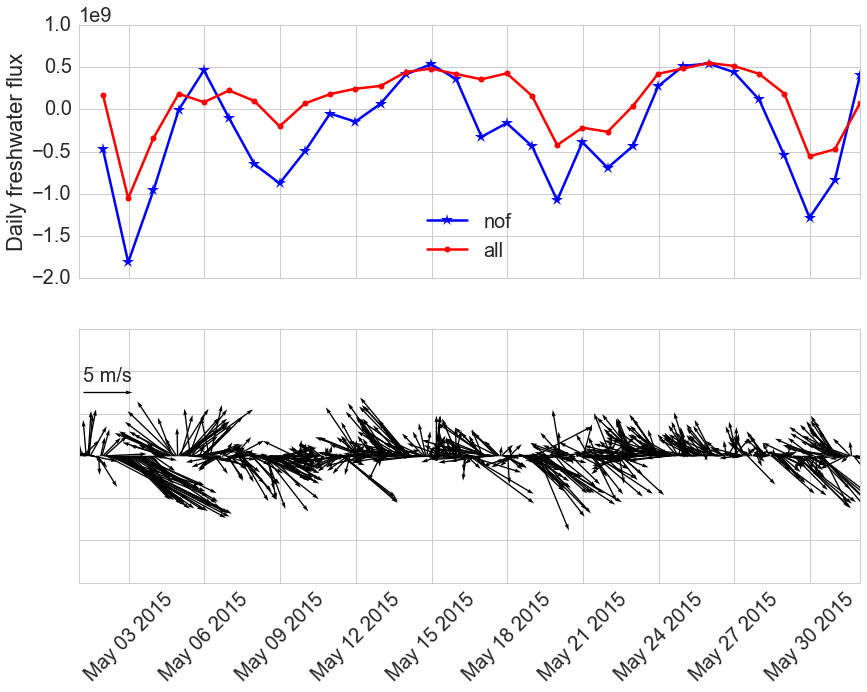

In [25]:
## may
fig,axs = plt.subplots(2,1,figsize = (14,10))
ax =axs[0]
ax.plot(t_daily,inte_weak_May['May2015nof'],'b*-',markersize = 12,label ='nof')
ax.plot(t_daily,inte_weak_May['May2015combineall'],'r.-',markersize = 12,label ='all')
ax.set_ylabel('Daily freshwater flux')
plt.setp(ax.get_xticklabels(), visible=False)
ax.legend(loc = 'best')

ax = axs[1] ## wind at Sandheads
quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_may[:],v_may[:],scale = 80,width=0.0017, color='k')
ax.quiverkey(quiver,md.date2num(t_wind)[4],1.03, 5, '',coordinates='data', color='black', labelcolor='black')
ax.text(md.date2num(t_wind)[4],1.035,'5 m/s', fontsize = 20)
plt.setp(ax.get_yticklabels(), visible=False)
for ax in axs: ## set xlims
    ax.set_xlim([t_start,t_end])
plt.xticks(rotation=45)
plt.show()

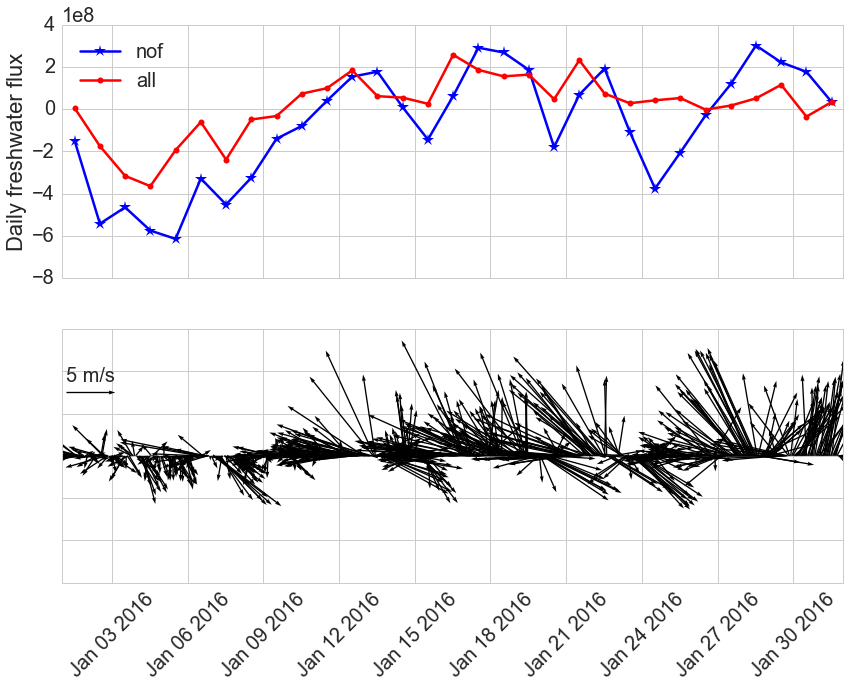

In [34]:
## jan
t_start = datetime.datetime(2016,1,1,0,30)
t_end = datetime.datetime(2016,1,31,23,30)
t_daily = [datetime.datetime(2016,1,d,12,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2016,1,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

fig,axs = plt.subplots(2,1,figsize = (14,10))
ax =axs[0]
ax.plot(t_daily,inte_weak_Jan['Jan2016nof'],'b*-',markersize = 12,label ='nof')
ax.plot(t_daily,inte_weak_Jan['Jan2016combineall'],'r.-',markersize = 12,label ='all')
ax.set_ylabel('Daily freshwater flux')
plt.setp(ax.get_xticklabels(), visible=False)
ax.legend(loc = 'best')

ax = axs[1] ## wind at Sandheads
quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_jan[:],v_jan[:],scale = 80,width=0.0017, color='k')
ax.quiverkey(quiver,md.date2num(t_wind)[4],1.03, 5, '',coordinates='data', color='black', labelcolor='black')
ax.text(md.date2num(t_wind)[4],1.035,'5 m/s', fontsize = 20)
plt.setp(ax.get_yticklabels(), visible=False)
for ax in axs: ## set xlims
    ax.set_xlim([t_start,t_end])
plt.xticks(rotation=45)
plt.show()

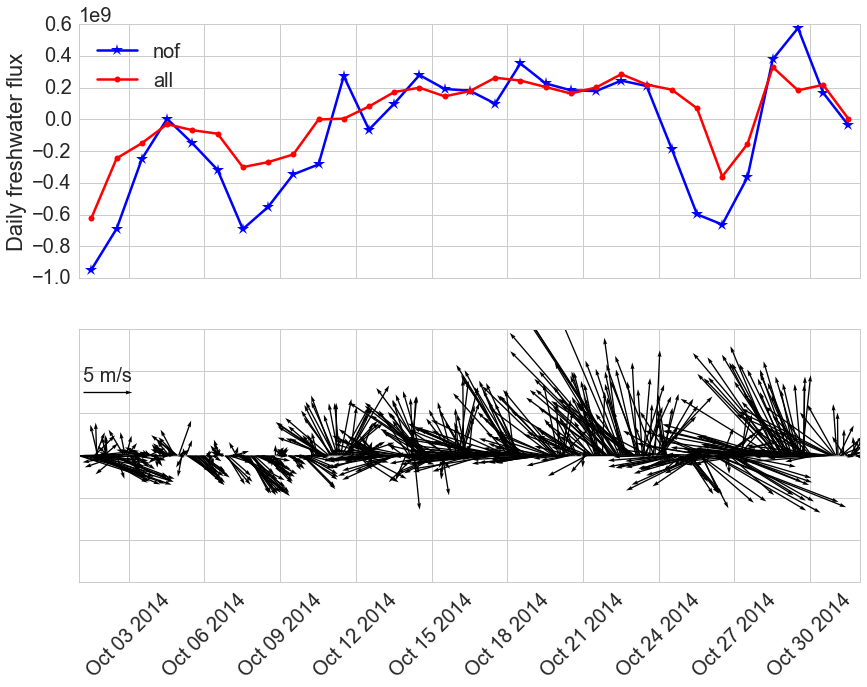

In [39]:
## oct
t_start = datetime.datetime(2014,10,1,0,30)
t_end = datetime.datetime(2014,10,31,23,30)
t_daily = [datetime.datetime(2014,10,d,12,30) for d in np.arange(1,32,1)]
t_wind = [datetime.datetime(2014,10,d,h,30) for d in np.arange(1,32,1) for h in np.arange(0,24)]

fig,axs = plt.subplots(2,1,figsize = (14,10))
ax =axs[0]
ax.plot(t_daily,inte_weak_Oct['Oct2014nof'],'b*-',markersize = 12,label ='nof')
ax.plot(t_daily,inte_weak_Oct['Oct2014combineall'],'r.-',markersize = 12,label ='all')
ax.set_ylabel('Daily freshwater flux')
plt.setp(ax.get_xticklabels(), visible=False)
ax.legend(loc = 'best')

ax = axs[1] ## wind at Sandheads
quiver = ax.quiver(md.date2num(t_wind),np.ones(1),u_oct[:],v_oct[:],scale = 80,width=0.0017, color='k')
ax.quiverkey(quiver,md.date2num(t_wind)[4],1.03, 5, '',coordinates='data', color='black', labelcolor='black')
ax.text(md.date2num(t_wind)[4],1.035,'5 m/s', fontsize = 20)
plt.setp(ax.get_yticklabels(), visible=False)
for ax in axs: ## set xlims
    ax.set_xlim([t_start,t_end])
plt.xticks(rotation=45)
plt.show()

# Plot salinity

(48.9, 49.5)

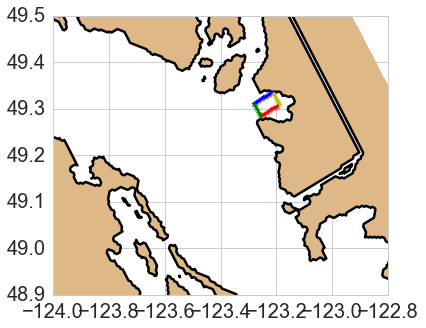

In [65]:
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
fig ,ax =plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.plot(X[86,82:95],Y[86,82:95],'b*') ## cross -strait
ax.plot(X[79,82:95],Y[79,82:95],'r*')
ax.plot(X[79:86,95],Y[79:86,95],'y*')
ax.plot(X[79:86,82],Y[79:86,82],'g*')
ax.set_xlim([-124.,-122.8])
ax.set_ylim([48.9,49.5])

In [76]:
def Get_Salinity(S,paths,strings,ebb_ts,jstart,jend,istart,iend):
    """
    """
    S_EnglishBay = {}
    for string in strings:
        S_EnglishBay[string] = [] ## a list
    for path, string in zip(paths,strings):
        print(path,string)
        for t in ebb_ts:
            S_EnglishBay[string].append(np.nanmean(S[path][t,0,jstart:jend,istart:iend]))
    return S_EnglishBay

In [72]:
## Peak ebb times in the month 

PEC = {} ## short form of peak ebb currents!
PET = {}## short form of peak ebb times!
for month in ['jan','oct','may']:
    PEC[month] = [];
    PET[month] = [];
    
for month, monthh in zip(['jan','oct','may'],['Jan2016combineall','Oct2014combineall','May2015combineall']):
    for t in np.arange(0,len(U[monthh]),24):
        pec = np.nanmax(U[monthh][t:t+24,0,38,72])
        PEC[month].append(pec)
        pet = np.nanargmax(U[monthh][t:t+24,0,38,72])+t
        PET[month].append(pet)

In [77]:
## Jan
jstart = 79
jend = 87
istart = 82
iend = 95
strings = ['nof','all']
paths = ['Jan2016nof','Jan2016combineall']
S_EnglishBay_jan = Get_Salinity(S,paths,strings,PET['jan'],jstart,jend,istart,iend)

Jan2016nof nof
Jan2016combineall all


In [80]:
## Oct
paths = ['Oct2014nof','Oct2014combineall']
S_EnglishBay_oct = Get_Salinity(S,paths,strings,PET['oct'],jstart,jend,istart,iend)

Oct2014nof nof
Oct2014combineall all


In [82]:
## May
paths = ['May2015nof','May2015combineall']
S_EnglishBay_may = Get_Salinity(S,paths,strings,PET['may'],jstart,jend,istart,iend)

May2015nof nof
May2015combineall all


In [84]:
## Times
t_jan = [datetime.datetime(2016,1,day) for day in np.arange(1,32)]
t_oct = [datetime.datetime(2014,10,day) for day in np.arange(1,32)]
t_may = [datetime.datetime(2015,5,day) for day in np.arange(1,32)]

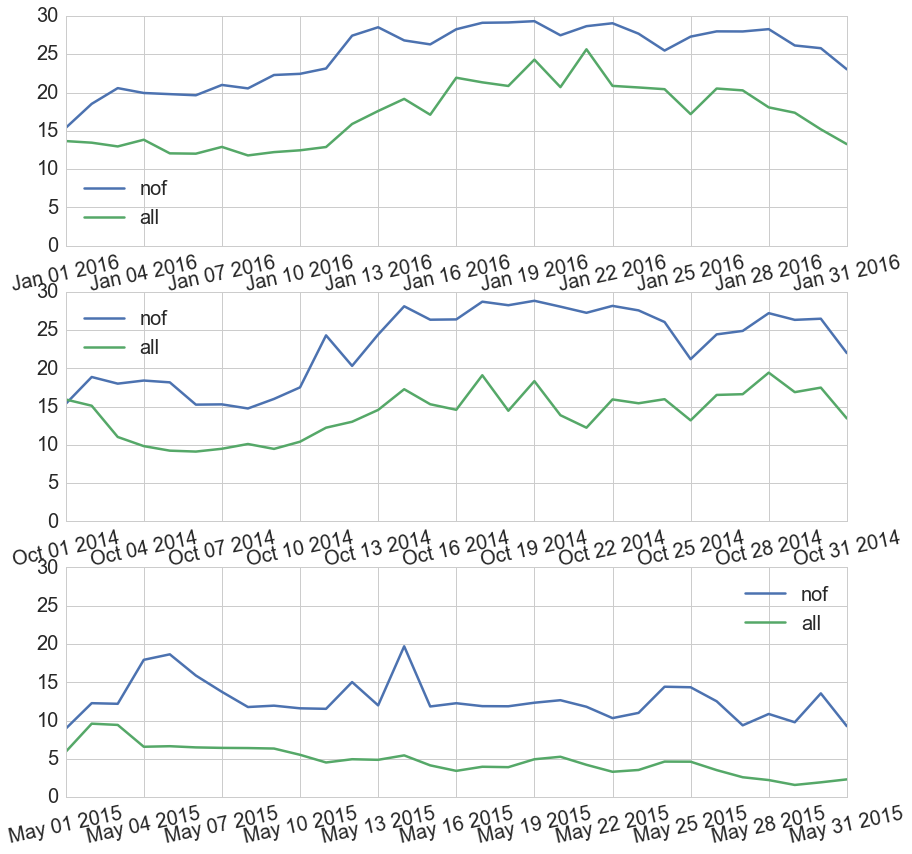

In [91]:
## plot
fig, axs = plt.subplots(3,1,figsize = (14,14))
for ax, plot_obj, t in zip(axs, [S_EnglishBay_jan,S_EnglishBay_oct,S_EnglishBay_may],[t_jan,t_oct,t_may]):
    for string in strings:
        ax.plot(t,plot_obj[string],label = string)
        ax.set_ylim([0,30])
        ax.set_ylabel('Practical Salinity')
    ax.legend(loc = 'best') 
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=12)